# Runoff calculations

*updated February 2026* - needs revision

## Introduction

A typical SWB application makes use of the SCS curve number methodology in order to estimate daily runoff amounts. For Maui, researchers felt that the curve number approach did not generate representative runoff amounts; instead, they developed a set of monthly runoff ratios that relate the runoff to rainfall. These runoff ratios are supplied in tabular form.

## Preliminaries


In [1]:
import os
import numpy as np
import pandas as pd
from osgeo import gdal

from plot_and_table_functions import ( read_raster,
                                       make_plot,
                                       make_scatter,
                                       discrete_cmap,
                                       discrete_irreg_cmap,
                                       discrete_random_cmap )
# lookup table path and filenames
lu_lookup_fname  = '../std_input/Landuse_lookup_maui.txt'

# grid files
runoff_zone_grid_filename      = '../input/maui_RUNOFF_ZONE__50m.asc'
runoff_ratio_table             = '../input/monthly_runoff_ratios_maui_2000_2010_TRANSPOSED.txt'

## Read grids and tables

In [2]:
# open table files
runoff_ratios     = pd.read_table( runoff_ratio_table )

In [3]:
# read in runoff zone grid
ro_data, ro_gt, ro_proj, ro_xy        = read_raster( runoff_zone_grid_filename )

c:\Users\smwesten\.local\share\mamba\envs\py312\Lib\site-packages\osgeo\gdal.py:606: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(



reading in ../input/maui_RUNOFF_ZONE__50m.asc into numpy array...
creating a grid of xy coordinates in the original projection...


## Input datasets and grids

### Runoff Zone Grid

Tabular information on runoff ratios is indexed to a set of 'runoff_zones'; SWB reads in the zone identifications from the grid file, and distributes the appropriate runoff ratios from the table on the basis of the runoff zone membership for each cell. There is a rather large number of runoff zones defined:

In [4]:
len( np.unique( ro_data.flatten() ) )

766

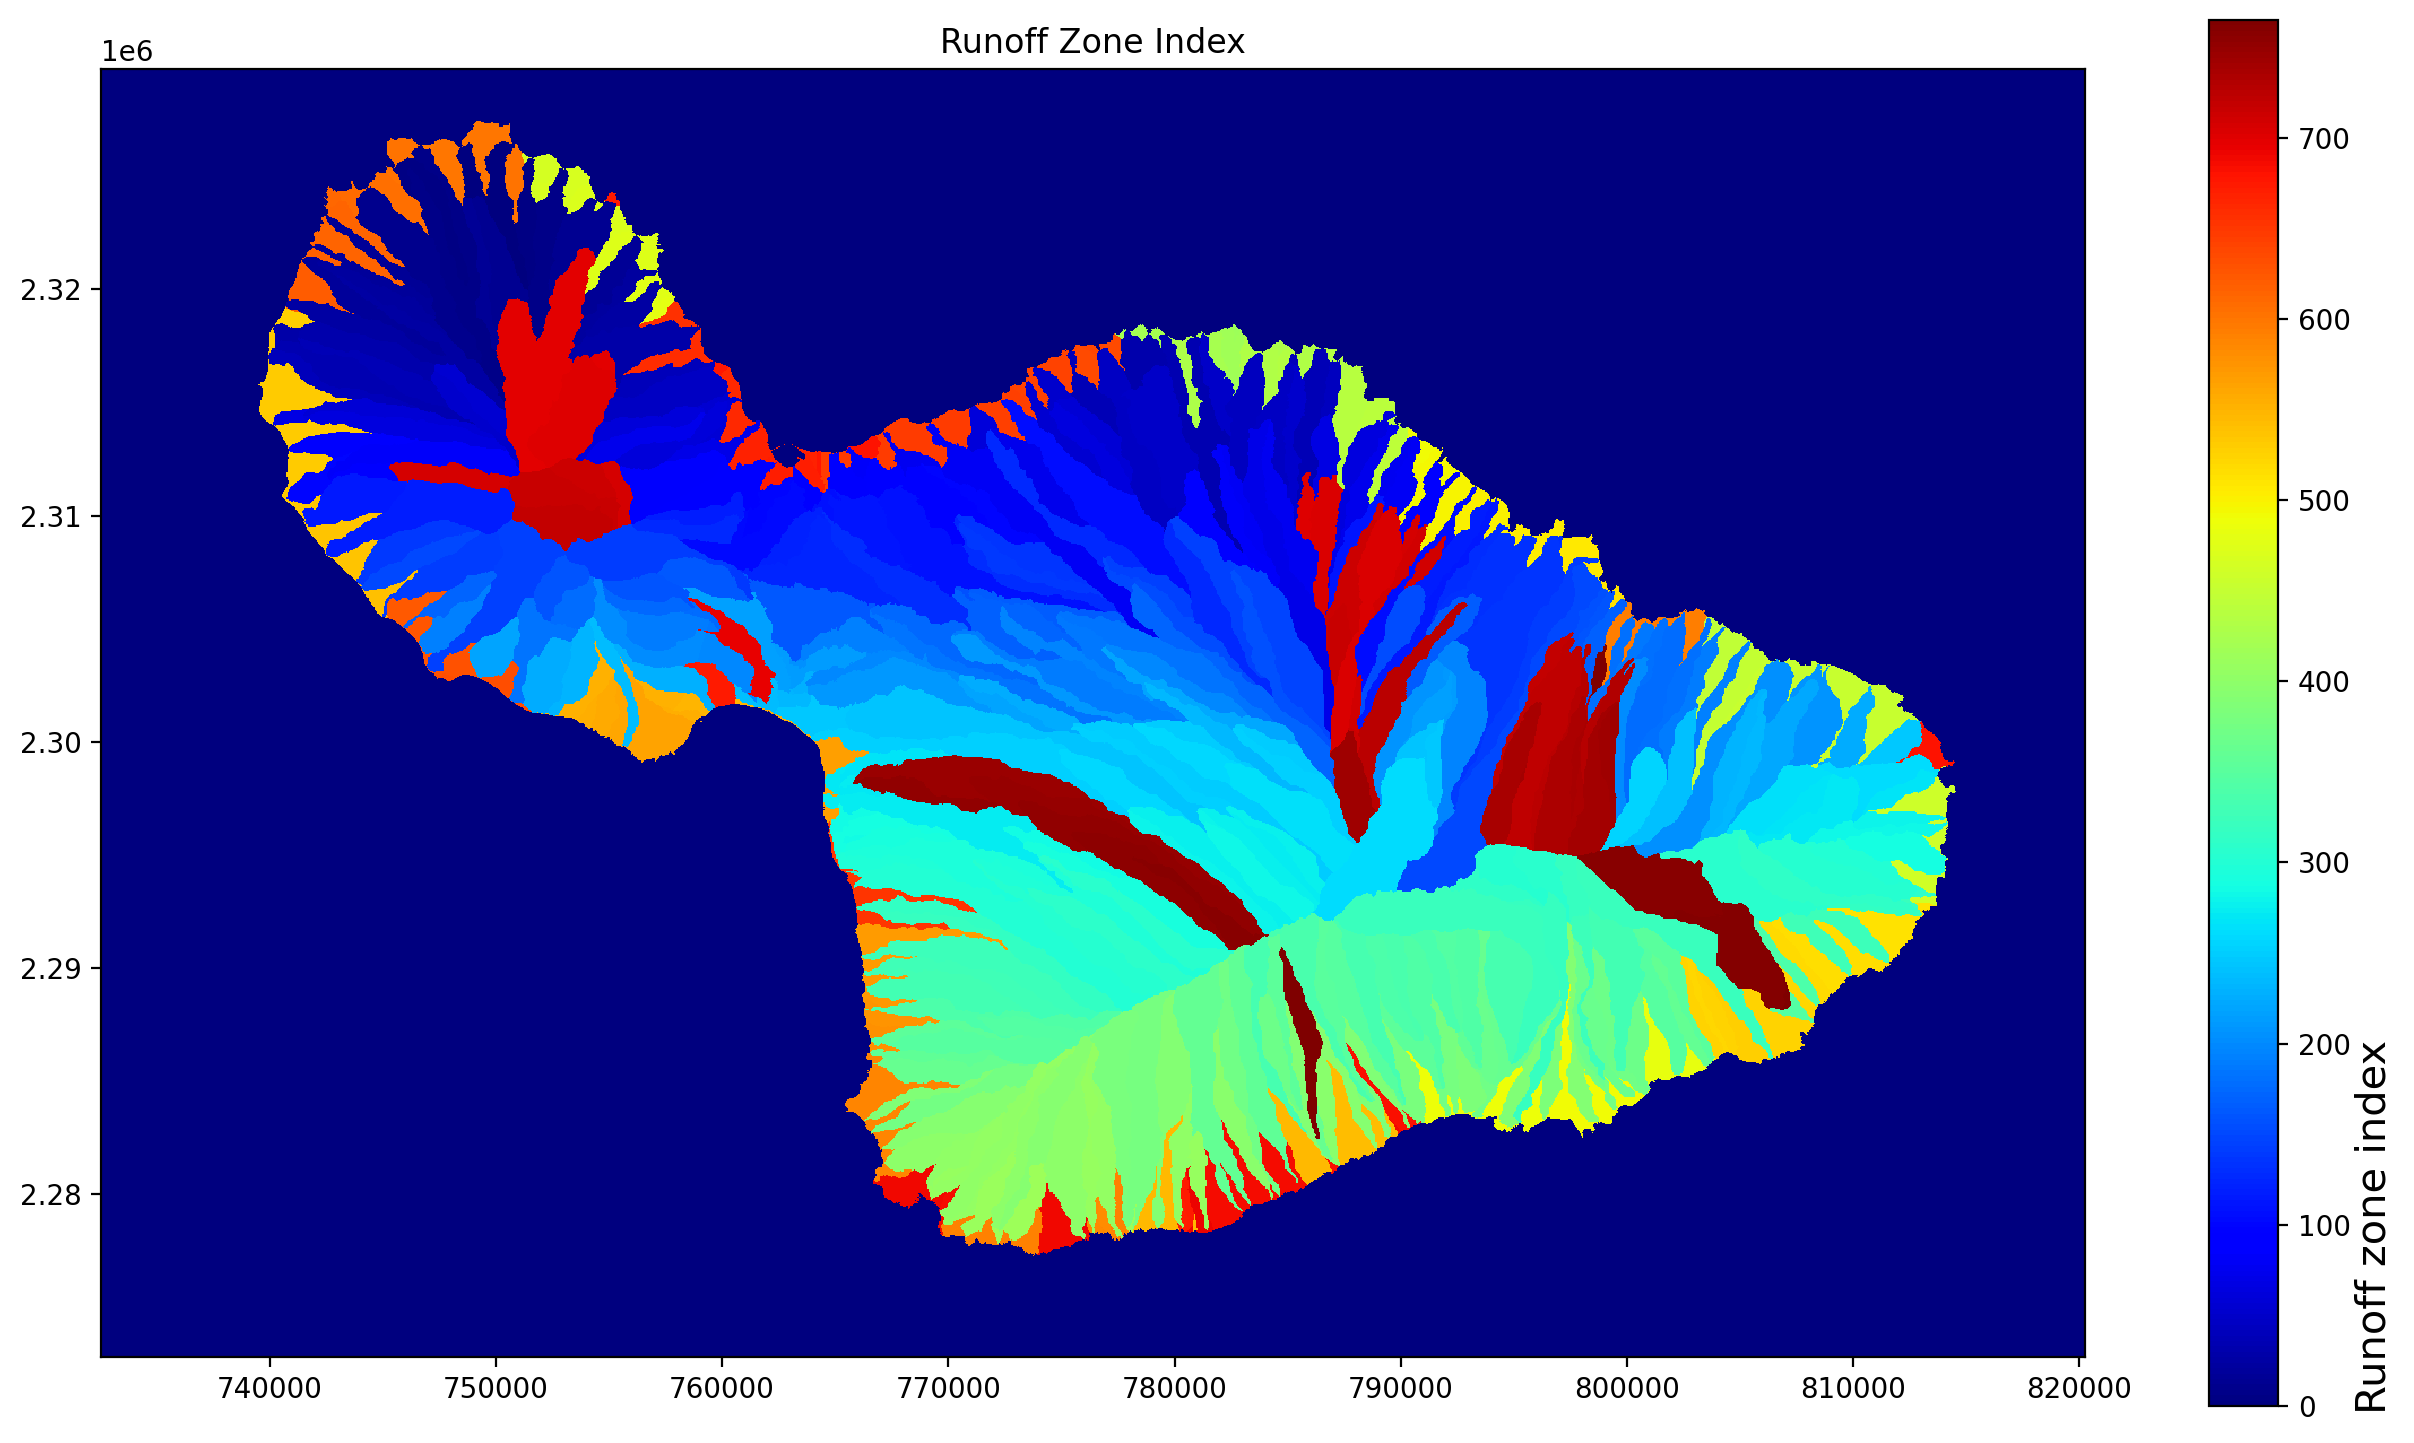

In [5]:
make_plot( x=ro_xy[0], y=ro_xy[1], var=ro_data, discrete=False, title='Runoff Zone Index',
           barlabel='Runoff zone index')

### Runoff Ratio Table

Only a small subset of the runoff ratio file will be shown; the actual table contains a column for each runoff zone (767 in all) plus a date column.

In [7]:
## Examination of Table Values

runoff_ratios = runoff_ratios.iloc[ 0:15, 0:16 ]

#sequence = sequence.loc[0:130,:]
print(runoff_ratios.head().to_string(index=False))

      Date      1      2      3      4      5     6      7      8      9     10     11     12     13     14     15
01/01/2000 0.2705 0.2182 0.3372 0.0626 0.0963 0.385 0.1555 0.3753 0.0542 0.1192 0.1005 0.3542 0.4001 0.4429 0.3905
02/01/2000 0.2705 0.2182 0.3372 0.0626 0.0963 0.385 0.1555 0.3753 0.0542 0.1192 0.1005 0.3542 0.4001 0.4429 0.3905
03/01/2000 0.2705 0.2182 0.3372 0.0626 0.0963 0.385 0.1555 0.3753 0.0542 0.1192 0.1005 0.3542 0.4001 0.4429 0.3905
04/01/2000 0.2705 0.2182 0.3372 0.0626 0.0963 0.385 0.1555 0.3753 0.0542 0.1192 0.1005 0.3542 0.4001 0.4429 0.3905
05/01/2000 0.2167 0.1398 0.2788 0.0645 0.0956 0.300 0.1483 0.3093 0.0573 0.1175 0.1002 0.2859 0.3422 0.3597 0.3229


## Application

For each model simulation day, SWB checks to see whether the runoff ratio remains applicable. If the simulation day is the first day of a month, the new runoff ratios are distributed to the gridcells. Runoff for a given day is determined by multiplying the cell's runoff ratio by the rainfall amount.

## Control File Entries

In order to use a set of runoff ratios in SWB 2, the control file must be modified, specifically, by changing the method by which runoff is calculated:

```
RUNOFF_METHOD     RUNOFF_RATIO
```

Somewhere in the control file, the required gridfile and tabular data file must be specified. In the example control file, these entries are included in block 9:

```
(9) Runoff-related data and grid
--------------------------------

RUNOFF_ZONE ARC_GRID input/maui_RUNOFF_ZONE__50m.asc
RUNOFF_ZONE_PROJECTION_DEFINITION +proj=utm +zone=4 +ellps=WGS84 +datum=WGS84 +units=m +no_defs

RUNOFF_RATIO_MONTHLY_FILE input/monthly_runoff_ratios_maui_2000_2010_TRANSPOSED.txt
```